In [2]:
import os
if os.getcwd().endswith('/notebook'):
    os.chdir('..')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import OrderedDict
import pandas as pd
import joblib 
from evaluation import create_test_set_from_positive_examples_same_freq, \
        create_test_set_from_positive_examples_unigram_freq

In [4]:
df = pd.read_csv('output/ontonote-svo.txt', sep='\t', names=['sbj', 'verb', 'dobj'])
df.sample(5)

,sbj,verb,dobj
20161,humiliation,stir,sense
1202,earthquake,damage,home
12181,side,undertake,effort
2595,resident,submit,application
18601,country,suffer,lot


In [5]:
print('{0:,d}'.format(len(df)))

20,885


Test set will also contain negative examples chosen in two ways:

- according to the unigram frequency in the dataset
- from the same frequency band as the positive subject/object being replaced

Following Cruys (2014), we will perform instance-based training and type-based testing. The duplicates in the training set gives the model a sense of typicality.

In [6]:
test_ds_same_freq = create_test_set_from_positive_examples_same_freq(df, random_seed=32532)

In [7]:
test_ds_same_freq.to_csv('output/ontonote-svo-same-freq.txt', sep='\t', index=False, header=False)

In [8]:
test_ds_unigram = create_test_set_from_positive_examples_unigram_freq(df, random_seed=32532)

In [9]:
test_ds_unigram.to_csv('output/ontonote-svo-unigram-freq.txt', sep='\t', index=False, header=False)

# Examine the datasets

In [10]:
test_ds_same_freq.head()

,verb,pos_sbj,pos_dobj,neg_sbj,neg_dobj
0,toss,judge,verdict,station,director
1,give,fact,measure,suspect,water
2,reach,bicycle,barrier,impression,platform
3,pay,defendant,damage,yield,trade
4,have,country,troop,article,everyone


In [11]:
def compute_examine_dataset(df):
    test_pos_examine = (df[['pos_sbj', 'verb', 'pos_dobj']].copy()
                        .rename(columns={'pos_sbj': 'sbj', 'pos_dobj': 'dobj'}))
    test_pos_examine['type'] = 'test_pos'
    test_neg_examine = (df[['neg_sbj', 'verb', 'neg_dobj']].copy()
                        .rename(columns={'neg_sbj': 'sbj', 'neg_dobj': 'dobj'}))
    test_neg_examine['type'] = 'test_neg'
    return pd.concat([test_pos_examine, test_neg_examine])

In [24]:
def plot_most_common_words(col_name, *args, **kwargs): 
    df = kwargs['data']
    df[col_name].value_counts().head(30).plot('bar', fontsize='small')
    
def plot_histogram(col_name, *args, **kwargs): 
    df = kwargs['data']
    plt.plot(df[col_name].value_counts().values)

In [13]:
ds_examine = compute_examine_dataset(test_ds_same_freq)

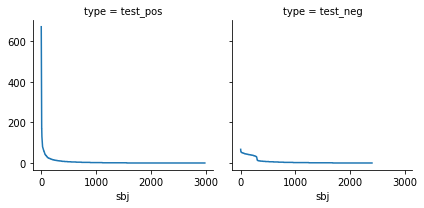

In [30]:
g = sns.FacetGrid(ds_examine, col='type').map_dataframe(plot_histogram, 'sbj')

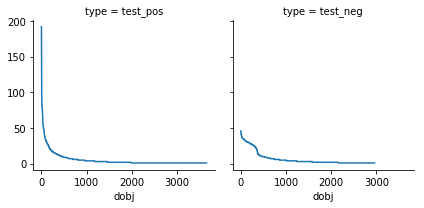

In [29]:
g = sns.FacetGrid(ds_examine, col='type').map_dataframe(plot_histogram, 'dobj')

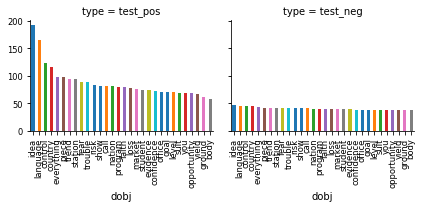

In [31]:
g = sns.FacetGrid(ds_examine, col='type').map_dataframe(plot_most_common_words, 'dobj')

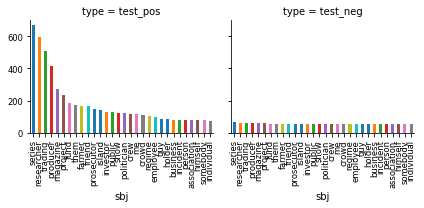

In [32]:
g = sns.FacetGrid(ds_examine, col='type').map_dataframe(plot_most_common_words, 'sbj')

In [17]:
test_ds_same_freq.sample(10)

,verb,pos_sbj,pos_dobj,neg_sbj,neg_dobj
4147,admit,none,allegation,panel,transition
8051,implement,government,reform,issue,stage
7320,spend,committee,time,office,president
7507,reach,purchase,recipient,plan,guidance
19411,receive,kind,comment,none,victory
9491,have,people,friendship,profit,worth
14483,give,computer,information,follower,judge
2281,have,lender,doubt,form,part
5272,make,premier,promise,chairman,credit
3418,stimulate,rebate,sale,comedy,view


In [18]:
ds_examine2 = compute_examine_dataset(test_ds_unigram)

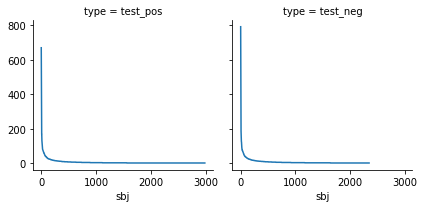

In [27]:
g = sns.FacetGrid(ds_examine2, col='type').map_dataframe(plot_histogram, 'sbj')

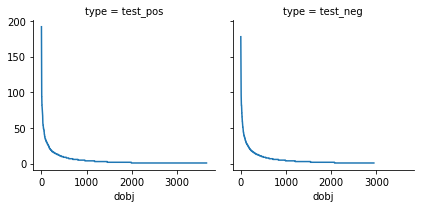

In [28]:
g = sns.FacetGrid(ds_examine2, col='type').map_dataframe(plot_histogram, 'dobj')

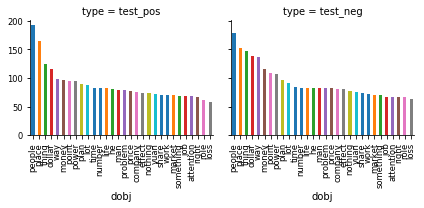

In [21]:
g = sns.FacetGrid(ds_examine2, col='type').map_dataframe(plot_most_common_words, 'dobj')

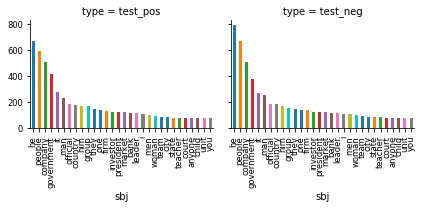

In [22]:
g = sns.FacetGrid(ds_examine2, col='type').map_dataframe(plot_most_common_words, 'sbj')

In [23]:
test_ds_unigram.sample(10)

,verb,pos_sbj,pos_dobj,neg_sbj,neg_dobj
12996,make,man,statement,friendship,period
9468,carry,worker,repair,group,trust
12741,represent,he,force,incident,volatility
15548,debate,official,fate,officer,sibling
14327,prevent,luck,wave,company,fire
1741,do,member,chore,investor,money
2121,generate,shock,impulse,judge,good
13812,fell,future,point,anyone,supplier
10578,turn,demonstrator,fury,lawmaker,jury
12745,offer,it,promotion,it,speech


# Encode into numerical values

In [43]:
encoder = joblib.load('output/ukwac-encoder.pkl')
vocab = set(encoder.classes_)

In [44]:
def transform_dataset(df):
    num_cols = len(df.columns)
    vals = df.values.reshape(-1)
    vals = [(v if v in vocab else '<unkn>') for v in vals]
    x = encoder.transform(vals).reshape(-1, num_cols)
    return x

In [45]:
encoded_test_ds_same_freq = transform_dataset(test_ds_same_freq)
encoded_test_ds_unigram = transform_dataset(test_ds_unigram)

In [46]:
encoded_test_ds_same_freq[:5]

array([[ 5251,  7885,  6446, 10394,  3317],
       [ 9954, 11123,  5126,  3938,  6744],
       [12781,  5608,  1039, 11645, 10400],
       [ 9666,  6541,  7637,  1290, 10488],
       [ 6414,  6093,  3451,  9112,  4570]])

In [47]:
encoded_test_ds_unigram[:5]

array([[ 5251,  7885,  6446,  6221, 10822],
       [ 9954, 11123,  5126, 11860, 11511],
       [12781,  5608,  1039,  7216,  8119],
       [ 9666,  6541,  7637,  3157,  8813],
       [ 6414,  6093,  3451, 10481, 11595]])

In [48]:
import numpy as np
np.save('output/ontonote-svo-same-freq.npy', encoded_test_ds_same_freq)
np.save('output/ontonote-svo-unigram-freq.npy', encoded_test_ds_unigram)

# Vocabulary coverage

In [52]:
count_in_vocab = sum(1 for w in test_ds_same_freq.values.flatten() if w in vocab)
count_in_vocab / test_ds_same_freq.values.size

0.9675645342312009

In [53]:
count_in_vocab = sum(1 for w in test_ds_unigram.values.flatten() if w in vocab)
count_in_vocab / test_ds_unigram.values.size

0.967289052137537